# **Stock Price Prediction using Long Short Term Memeroy LSTM**

**What is LSTM**

LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) that is particularly good at learning patterns in sequential data like time series, text, or speech. Unlike standard neural networks, LSTMs have feedback loops, which allow them to maintain information across sequences.

In the context of stock price prediction:

The LSTM model can "remember" trends or patterns from previous days or weeks, making it ideal for predicting future stock prices based on past prices and other factors.
LSTM overcomes the limitations of standard RNNs by using gates (forget, input, and output gates) to decide what information to keep or discard over long sequences.

Step-by-Step Summary:
1. Data Loading: We downloaded Apple stock data from Yahoo Finance.
2. Data Cleaning: Replaced any "null" values with NaN and ensured that numeric fields are correctly formatted.
3. Data Preparation: Calculated moving averages for trend analysis and created training/test datasets based on historical closing prices.
4. Data Scaling: Scaled the data to a range of 0 to 1 using MinMaxScaler, which helps the LSTM model converge more efficiently.
5. Model Building: We created an LSTM model with two LSTM layers and a Dense layer for predicting the closing price of Apple stock based on the previous 60 days of data.
6. Model Training: Trained the model using the training dataset, with one epoch and a batch size of 10.
7. Model Testing: Prepared the test dataset and generated predictions for the stock prices.
8. Model Evaluation: Calculated the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) to quantify how well the model predicted the stock prices.
9. Visualization: Plotted the true vs predicted stock prices for a clear comparison of model performance.

In [241]:
# Importing the necessary libraries for data manipulation, visualization, and modeling
import pandas as pd  # For handling and analyzing data in DataFrame format
from pandas_datareader import data as pdr  # To get financial data from sources like FRED (Federal Reserve)
import numpy as np  # For numerical operations on arrays
import yfinance as yf  # To fetch stock data from Yahoo Finance
import matplotlib.pyplot as plt  # For plotting and visualizing data
from sklearn.preprocessing import MinMaxScaler  # For scaling data before feeding into the model
from keras.models import Sequential  # To build the deep learning model (LSTM)
from keras.layers import LSTM, Dense, Input  # LSTM layer and Dense layers for neural networks
import math  # For mathematical operations like ceiling

In [242]:
# Step 1: Download Stock Data for Apple (AAPL) using Yahoo Finance API
ticker_symbol = 'AAPL'  # Define the stock symbol for Apple

# Download the stock data from Yahoo Finance from 1980 to 2024
df = yf.download(ticker_symbol, start='1980-01-01', end='2024-09-19')

# Display the first few rows to understand the structure of the data
print(df.head())  # Outputs the first 5 rows to give us a preview of the dataset

# Optional: Save the dataset to a CSV file (can be useful if you want to share or save the data for later)
# df.to_csv(f'{ticker_symbol}.csv')

[*********************100%***********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600


In [243]:
# Step 2: Clean the Data

# Replace any string "null" values with actual NaN (Not a Number)
df.replace("null", np.nan, inplace=True)

# Check for missing data in the dataset
missing_data = df.isnull()

# Display how many missing values exist in each column for analysis
print("Missing Data Summary:\n")
for column in missing_data.columns.values.tolist():
    # Count the missing and non-missing values for each column
    print(f"Column '{column}':")
    
    # Get counts of True (missing) and False (not missing)
    missing_count = missing_data[column].value_counts()
    
    # If no data is missing, display a clean message
    if True not in missing_count:
        print(f"  No missing data found")
    else:
        print(f"  Missing: {missing_count[True]}")
        print(f"  Not missing: {missing_count[False]}")
    
    # Extra space for readability between columns
    print(" ")

# Ensure that important columns are in the correct data type (floats) for numerical calculations
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype("float")


Missing Data Summary:

Column 'Open':
  No missing data found
 
Column 'High':
  No missing data found
 
Column 'Low':
  No missing data found
 
Column 'Close':
  No missing data found
 
Column 'Adj Close':
  No missing data found
 
Column 'Volume':
  No missing data found
 


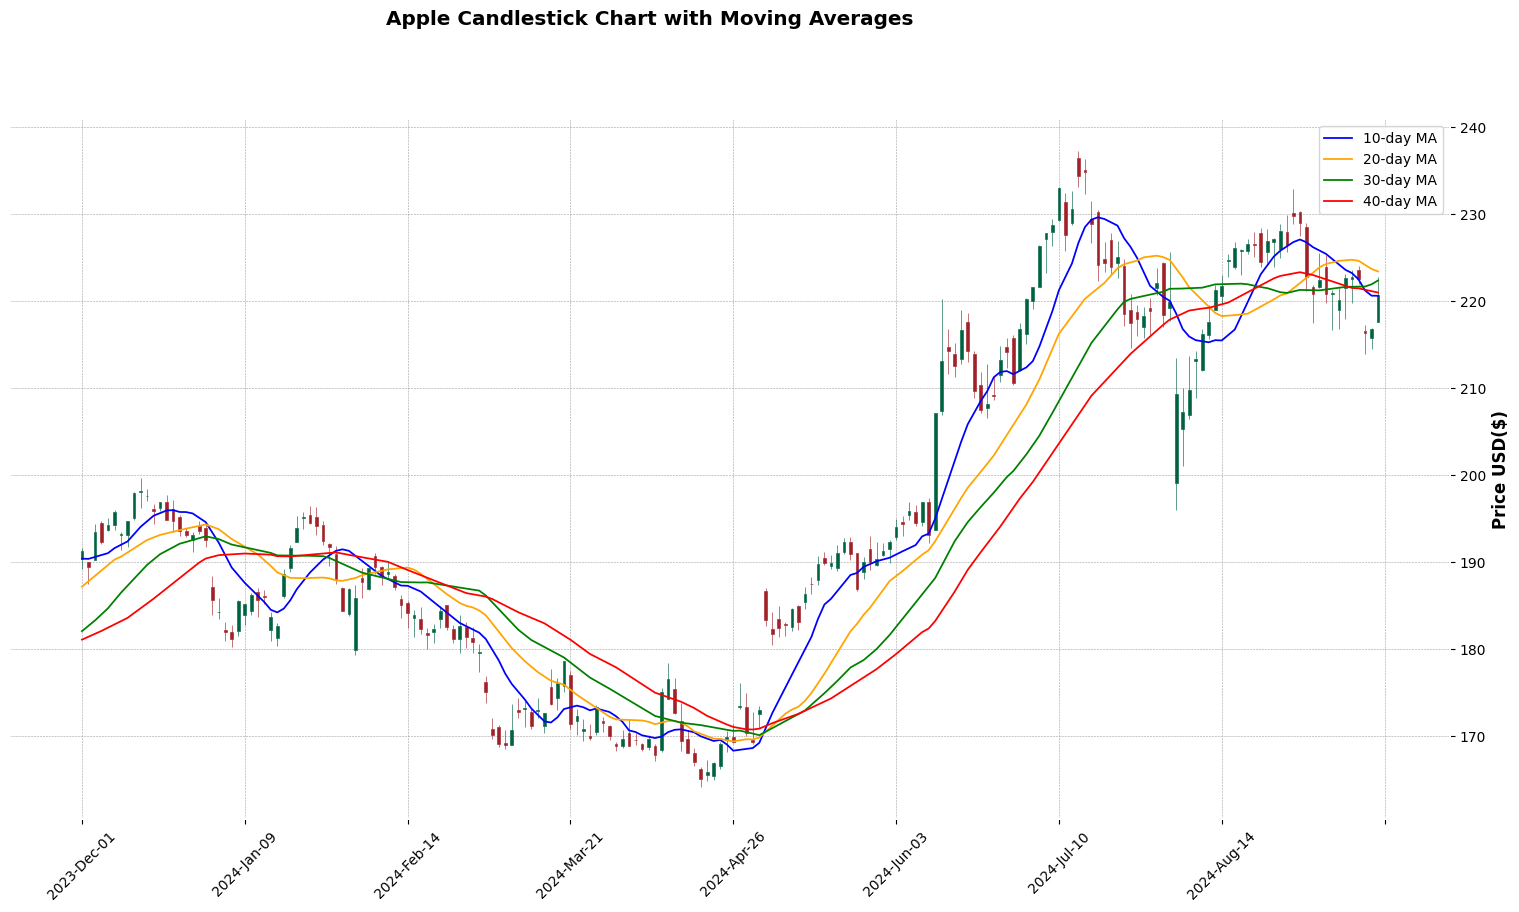

In [244]:
# Step 3: Create Moving Averages
# Moving averages help smooth out stock price data to identify trends. Here we create 10-day, 20-day, 30-day, and 40-day moving averages.
df_10 = df['Close'].rolling(window=10).mean()
df_20 = df['Close'].rolling(window=20).mean()
df_30 = df['Close'].rolling(window=30).mean()
df_40 = df['Close'].rolling(window=40).mean()

# Step 4: Plot a Candlestick Chart with Moving Averages
import mplfinance as mpf  # Import for candlestick chart plotting

# Plot the candlestick chart for the last 200 days of the dataset with 10, 20, 30, and 40-day moving averages
mpf.plot(df.tail(200), type='candle', style='charles', title='Apple Candlestick Chart with Moving Averages',
         ylabel='Price USD($)', volume=False, figsize=(20, 10), addplot=[
            mpf.make_addplot(df_10.tail(200), color='blue', label='10-day MA'),
            mpf.make_addplot(df_20.tail(200), color='orange', label='20-day MA'),
            mpf.make_addplot(df_30.tail(200), color='green', label='30-day MA'),
            mpf.make_addplot(df_40.tail(200), color='red', label='40-day MA'),
         ])


In [245]:
# Step 5: Preparing the Data for LSTM (Long Short-Term Memory) Model
# We only need the 'Close' price for the LSTM model
data = df.filter(['Close'])
dataset = data.values  # Convert to numpy array for easier processing

# Calculate the number of training samples (70% of the data will be used for training, the rest for testing)
training_data_len = math.ceil(len(dataset) * .7)

In [246]:
# Step 6: Scaling the Data
# LSTM models perform better when the data is scaled between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


In [247]:
# Step 7: Creating the Training Dataset
# Splitting the data into training and testing sets
train_data = scaled_data[0:training_data_len, :]  # Use the first 70% of the data for training

# Create two empty lists to hold the input (x_train) and output (y_train) sequences
x_train = []
y_train = []

# We use the previous 60 days to predict the stock price of the 61st day.
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])  # Add the last 60 days of prices to x_train
    y_train.append(train_data[i, 0])  # The target is the 61st day's price (what we want to predict)

# Convert the training data into numpy arrays, which are the required format for the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data into 3D arrays as required by the LSTM model (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

**The Two LSTM Layers and Dense Layer**

**First LSTM Layer:**
**LSTM(50, return_sequences=True):**
The 50 refers to the number of "neurons" or "units" in the LSTM layer. 

These neurons are responsible for learning the patterns from the input data (like stock prices and macroeconomic variables).
return_sequences=True means that this layer will return all time steps as output. In this case, it returns a sequence for each of the 60 previous days (our time steps). This is useful when stacking multiple LSTM layers, as the next LSTM layer needs access to the full sequence of data.

**Second LSTM Layer:**
**LSTM(50, return_sequences=False):**
This layer has another 50 neurons, but return_sequences=False means it will only return the final output from the last time step (day 60).

This layer learns deeper patterns from the data and compresses the sequential information from the previous layer into a single output that represents the stock price at day 60.

**Dense Layer:**
**Dense(25):**
A Dense layer is a fully connected layer, meaning each neuron from the previous layer is connected to every neuron in this layer.

In this case, the 25 neurons in this layer learn additional patterns from the LSTM layers' output.
This layer acts as a feature extractor that combines the information learned from the LSTM layers.
Final Dense Layer:

**Dense(1):**
This is the final layer with a single neuron because we're predicting a single value, the next day's stock price.
The neuron outputs the predicted stock price based on the learned patterns from the previous layers.

In [248]:
# Step 8: Building the LSTM Model
# LSTM (Long Short-Term Memory) is a type of neural network suitable for sequential data like stock prices.

model = Sequential()

# The Input layer tells the model the shape of the data (60 time steps, 1 feature)
model.add(Input(shape=(x_train.shape[1], 1)))

# First LSTM layer with 50 units (neurons), returning sequences means it outputs data for each time step
model.add(LSTM(50, return_sequences=True))

# Second LSTM layer with 50 units, but this one only returns the final output (not all time steps)
model.add(LSTM(50, return_sequences=False))

# Dense layer with 25 units (fully connected layer)
model.add(Dense(25))

# Final output layer with 1 unit (since we are predicting a single stock price)
model.add(Dense(1))

# Compile the model using the Adam optimizer and mean squared error (MSE) as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model for 1 epoch with a batch size of 10 (for simplicity, we use a small number of epochs)
model.fit(x_train, y_train, batch_size=20, epochs=3)

Epoch 1/3
384/384 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 2.8194e-05
Epoch 2/3
384/384 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - loss: 8.3247e-07
Epoch 3/3
384/384 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 7.9941e-07


In [249]:
# Step 9: Preparing the Testing Dataset
# Create the test dataset using the last 30% of the data (this wasn't used for training)

# The test data starts 60 days before the training data ends, because we need the last 60 days to predict the first test value
test_data = scaled_data[training_data_len-60:, :]
x_test = []
y_test = dataset[training_data_len:, :]  # The actual 'Close' prices for testing

# Generate x_test (input) based on the previous 60 days for each point in the test set
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert x_test to numpy arrays
x_test = np.array(x_test)

# Reshape x_test to 3D arrays as required by the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [250]:
# Step 10: Making Predictions with the LSTM Model
# Predict the stock prices for the test data
lstm_predictions = model.predict(x_test)

# Inverse transform the scaled predictions back to the original price scale
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Step 11: Evaluating the Model
# Calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) for the predictions
mse = np.mean(lstm_predictions - y_test) ** 2  # MSE: Measures average squared difference between predictions and actual values
rmse = np.sqrt(mse)  # RMSE: Square root of MSE, gives an idea of average error in price prediction
print(f'MSE: {mse}, RMSE: {rmse}')

104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
MSE: 16.197013384006578, RMSE: 4.0245513270433735


C:\Users\LyubomirVasi_1gncbm9\AppData\Local\Temp\ipykernel_22920\1225171602.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = lstm_predictions


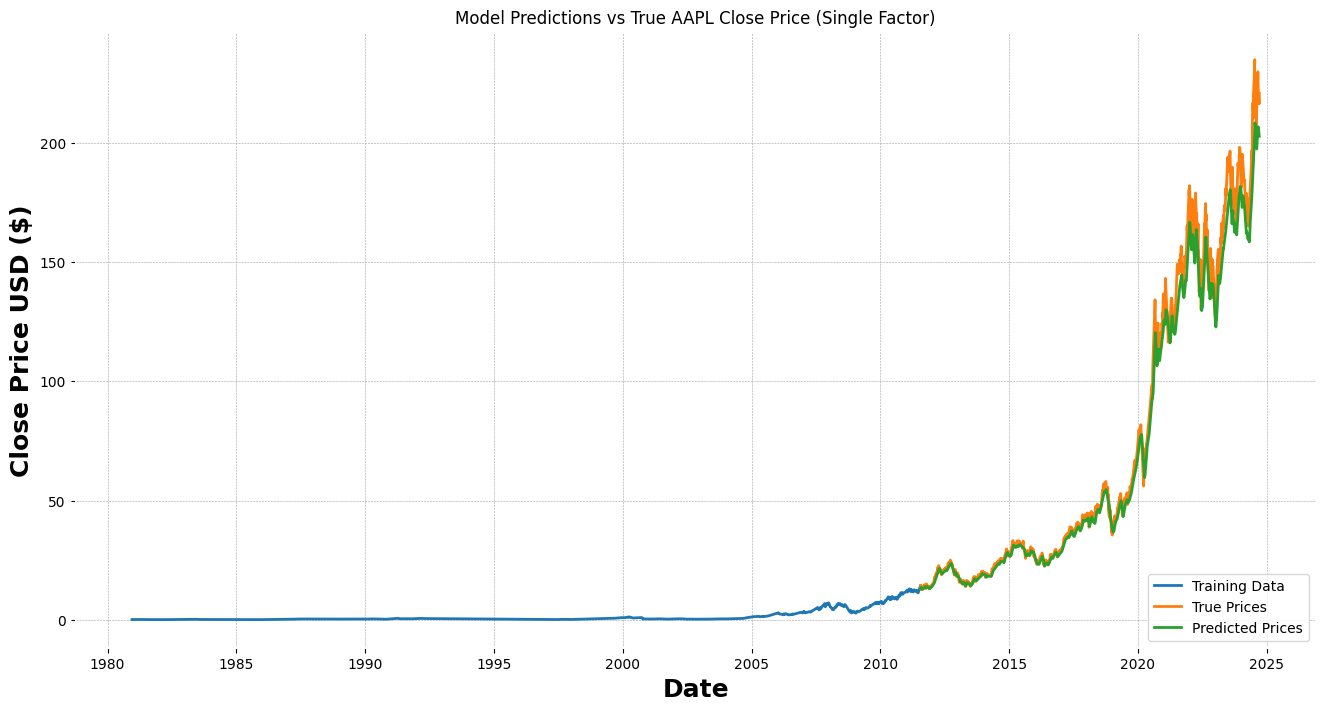

In [251]:
# Step 12: Plotting the Results
# Create a DataFrame with the actual closing prices and predicted values for easy comparison
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = lstm_predictions

# Plot the true values vs the predicted values for better visualization
plt.figure(figsize=(16, 8))
plt.title('Model Predictions vs True AAPL Close Price (Single Factor)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], label='Training Data')
plt.plot(valid[['Close', 'Predictions']], label=['True', 'Predictions'])

# Ensure the plot includes a legend to distinguish between true and predicted values
plt.legend(['Training Data', 'True Prices', 'Predicted Prices'], loc='lower right')

# Display the final plot that shows the true vs predicted stock prices
plt.show()

1. Macroeconomic Data: We added 90-day T-bills, 2-year interest rates, 10-year interest rates, and the difference between the 2-year and 10-year interest rates from FRED.
2. Data Preparation: The stock price data was combined with these macroeconomic variables, and they were all scaled and used as features in the model.
3. LSTM Model: The LSTM model now takes 5 features (Close price, T-Bill, 2Y, 10Y, Yield Difference) and uses these to predict future stock prices.
4. Evaluation: The model’s performance is measured using the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE).
5. Visualization: Both the actual stock prices and the predicted stock prices (using the additional macroeconomic variables) are plotted for comparison.

In [252]:
# Define the stock ticker symbol
ticker_aapl = 'AAPL'  # Apple stock symbol

# FRED tickers for additional macroeconomic data
ticker_tb = 'DTB3'    # 90-day T-bill
ticker_2y = 'DGS2'    # 2-year yield
ticker_10y = 'DGS10'  # 10-year yield
ticker_10_2_diff = 'T10Y2Y'  # Difference between 10-year and 2-year yields

# Download stock data for AAPL using Yahoo Finance
df_aapl = yf.download(ticker_aapl, start='1980-01-01', end='2024-09-19')

# Download additional financial data from FRED using pandas_datareader
df_tb = pdr.get_data_fred(ticker_tb, start='1980-12-12', end='2024-09-19')
df_2y = pdr.get_data_fred(ticker_2y, start='1980-12-12', end='2024-09-19')
df_10y = pdr.get_data_fred(ticker_10y, start='1980-12-12', end='2024-09-19')
df_10_2_diff = pdr.get_data_fred(ticker_10_2_diff, start='1980-12-12', end='2024-09-19')

# Prepare the T-bill and yield data
df_tb.rename(columns={'DTB3': 'T_Bill'}, inplace=True)  # Rename 90-day T-bill column
df_2y.rename(columns={'DGS2': '2Y_Yield'}, inplace=True)  # Rename 2-year yield column
df_10y.rename(columns={'DGS10': '10Y_Yield'}, inplace=True)  # Rename 10-year yield column
df_10_2_diff.rename(columns={'T10Y2Y': '10_2_Yield_Diff'}, inplace=True)  # Rename yield difference column

# Merge all datasets on the date index, ensuring that only rows with data for all columns are retained
df_combined = df_aapl.join([df_tb, df_2y, df_10y, df_10_2_diff])

# Handle any missing data by replacing "null" values and dropping rows with missing values
df_combined.replace("null", np.nan, inplace=True)
df_combined.dropna(inplace=True)

# Creating the dataset for modeling, using both stock price and macroeconomic variables
# Filter only the relevant columns: Close price, T-Bill, 2Y, 10Y, and Yield difference
data = df_combined.filter(['Close', 'T_Bill', '2Y_Yield', '10Y_Yield', '10_2_Yield_Diff'])
dataset = data.values  # Convert the data to a NumPy array

# Calculate the number of training samples (70% of the data for training)
training_data_len = math.ceil(len(dataset) * .7)

# Step 6: Scaling the Data
# Scale the data between 0 and 1 for better LSTM model performance
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data from the scaled dataset
train_data = scaled_data[0:training_data_len, :]

# Prepare x_train and y_train, using the last 60 days of data to predict the next day's 'Close' price
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])  # Use all features (T-Bill, 2Y, 10Y, etc.)
    y_train.append(train_data[i, 0])  # The target is the 'Close' price (column 0)

# Convert the training data to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the x_train array to be 3-dimensional (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

# Step 7: Building the LSTM Model
# Build the LSTM model using Sequential API from Keras
model = Sequential()

# Input shape for the model is (60 time steps, 5 features)
model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))

# First LSTM layer with 50 units, returning the sequences
model.add(LSTM(50, return_sequences=True))

# Second LSTM layer with 50 units, not returning the sequences (output only the last value)
model.add(LSTM(50, return_sequences=False))

# Fully connected Dense layer with 25 units
model.add(Dense(25))

# Output Dense layer with 1 unit (we are predicting a single value: the 'Close' price)
model.add(Dense(1))

# Compile the model with Adam optimizer and mean squared error as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the training data (with batch size of 10 and 1 epoch for now)
model.fit(x_train, y_train, batch_size=20, epochs=3)

[*********************100%***********************]  1 of 1 completed


Epoch 1/3
380/380 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 2.7155e-04
Epoch 2/3
380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 2.6261e-06
Epoch 3/3
380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 1.7453e-06


In [253]:
# Step 8: Preparing the Test Dataset
# Prepare the test data, which starts 60 days before the end of the training data
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, 0]  # The actual 'Close' prices (column 0) for testing

# Create the x_test dataset using the previous 60 days of data for each point in the test set
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])  # Use all features

# Convert x_test to NumPy array and reshape to 3D as required by the LSTM model
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# Step 9: Making Predictions with the LSTM Model
# Make predictions for the test data
lstm_predictions = model.predict(x_test)

# Inverse transform the scaled predictions back to the original price scale
predictions_scaled = np.concatenate((lstm_predictions, np.zeros((lstm_predictions.shape[0], dataset.shape[1] - 1))), axis=1)
lstm_predictions = scaler.inverse_transform(predictions_scaled)[:, 0]  # Extract only the 'Close' price from the transformed data

# Step 10: Evaluating the Model
# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = np.mean(lstm_predictions - y_test) ** 2
rmse = np.sqrt(mse)
print(f'MSE: {mse}, RMSE: {rmse}')


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
MSE: 45.875644369178914, RMSE: 6.773156160105783


C:\Users\LyubomirVasi_1gncbm9\AppData\Local\Temp\ipykernel_22920\1233436501.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = lstm_predictions  # Add the predicted prices to the DataFrame


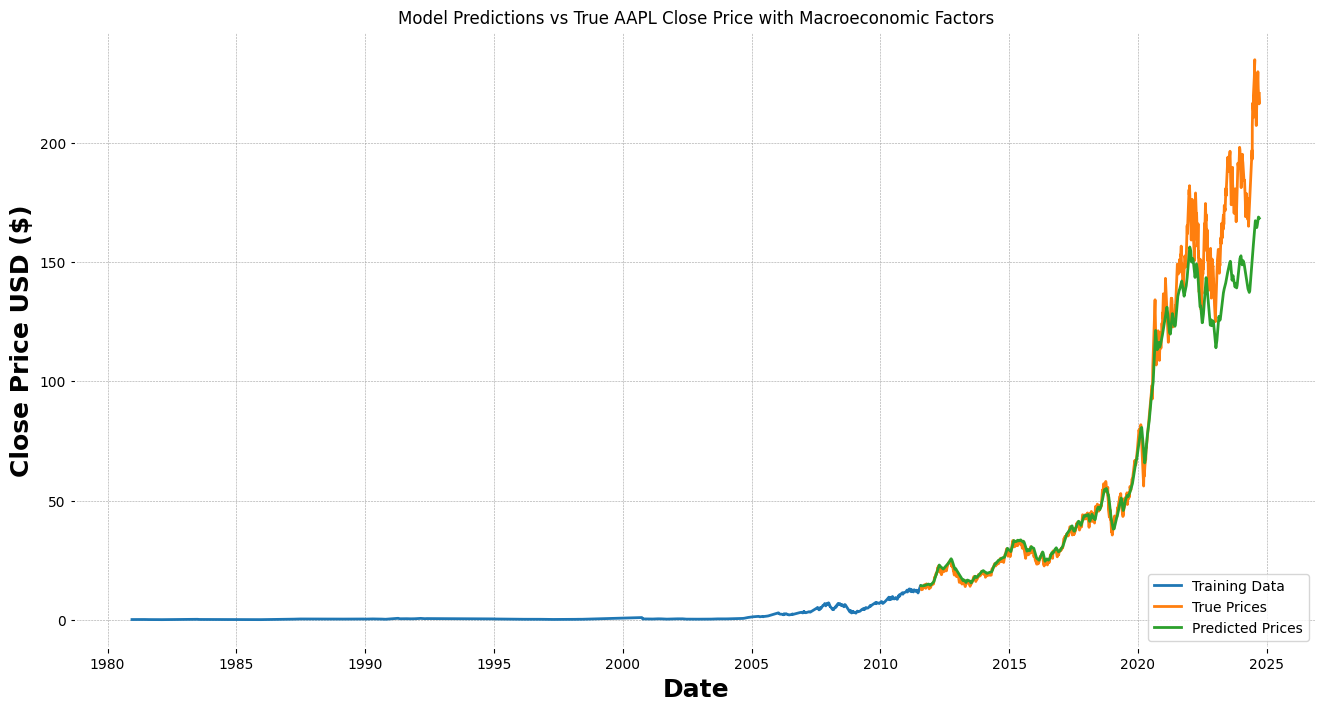

In [254]:
# Step 11: Visualizing the Results
# Create a DataFrame with the actual 'Close' prices and the predicted prices
valid = data[training_data_len:]
valid['Predictions'] = lstm_predictions  # Add the predicted prices to the DataFrame

# Plot the actual vs predicted prices
plt.figure(figsize=(16, 8))
plt.title('Model Predictions vs True AAPL Close Price with Macroeconomic Factors')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

# Plot the true 'Close' prices
plt.plot(data[:training_data_len]['Close'], label='Training Data')

# Plot both the true and predicted 'Close' prices for the test set
plt.plot(valid[['Close', 'Predictions']], label=['True Prices', 'Predicted Prices'])

# Display the plot with a legend
plt.legend(loc='lower right')
plt.show()
